In this project, we will detect fake news using Natural Language Processing concepts.

First, let us import the required libraries.

In [179]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.datasets import make_classification
%matplotlib inline

# Data Exploration

In [180]:
fake_df = pd.read_csv("fake_or_real_news.csv")

In [181]:
rows = fake_df.shape[0]
cols = fake_df.shape[1]
print 'The data set has %d rows and %d cols' % (rows,cols)

The data set has 6335 rows and 4 cols


In [182]:
fake_df.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [183]:
fake_df = fake_df.set_index("Unnamed: 0")

In [184]:
fake_df.head(10)

,title,text,label
Unnamed: 0,,,
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL


# Extracting the training data

We now want to seperate the labels and split the data into a training and testing sets.

Since I will be using bag-of-words and Term Frequency–Inverse Document Frequency (TF-IDF) to extract features, I have decided to use longer article text. This allows for distinct words and features for the real and fake news data.

In [185]:
# Set `y` 
y = fake_df.label 

# Drop the `label` column
fake_df.drop("label", axis=1)

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(fake_df['text'], y, test_size=0.33, random_state=53)

As seen in the code above, we keep around 33% of data for the testing set, and the rest for the training set.

# Building Vectorizer Classifiers

Now that we have our training and testing data, it is time to build our vectorizer classifiers. We use two different types of vectorizers to determine whether the words and tokens in the article had any influence on whether the news was fake or real. The two types of vectorizers are CountVectorizer and TfidfVectorizer. 

We set the maximum threshold for the TfidfVectorizer to 0.7 using the maxDf argument. This enables us to remove words that appear in more than 70% of the articles.

In [186]:
# Initialize the count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [187]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

We have the vectors, and now want to explore the features in these vectors. There are multilingual words in the data set, and we have to find a way to overcome these issues and make sure that our model properly classifies words.

In [188]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

[u'\u062d\u0644\u0628', u'\u0639\u0631\u0628\u064a', u'\u0639\u0646', u'\u0644\u0645', u'\u0645\u0627', u'\u0645\u062d\u0627\u0648\u0644\u0627\u062a', u'\u0645\u0646', u'\u0647\u0630\u0627', u'\u0648\u0627\u0644\u0645\u0631\u0636\u0649', u'\u0e22\u0e07ade']
[u'00', u'000', u'0000', u'00000031', u'000035', u'00006', u'0001', u'0001pt', u'000ft', u'000km']


# Count vs TF-IDF Vectorizers

We want to check whether both vectorizers had extracted different tokens, and to do this we extract vector information back in to a DataFrame to easily compare in Python.

In [189]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

In [190]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [191]:
difference = set(count_df.columns) - set(tfidf_df.columns)
difference

set()

In [192]:
print(count_df.equals(tfidf_df))

False


Both vectorizers extract the same tokens, but both have different weights.

In [193]:
count_df.head(10)

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
tfidf_df.head(10)

,00,000,0000,00000031,000035,00006,0001,0001pt,000ft,000km,...,حلب,عربي,عن,لم,ما,محاولات,من,هذا,والمرضى,ยงade
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.012499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.012147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.016580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Comparing Models

MultinomialNB can be used to compare CountVectorizer and TF-IDF. 

Confusion matrixes are easy-to-read matrixes, and we will implement them here since they portray labels clearly on the main diagonal. I do this by referring to the scikit-learn documentation. 

In [195]:
#This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    #condition for when the confusion matrix is normalized
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    #label the axis of the plot
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [196]:
clf = MultinomialNB() 

accuracy:   0.857
Confusion matrix, without normalization


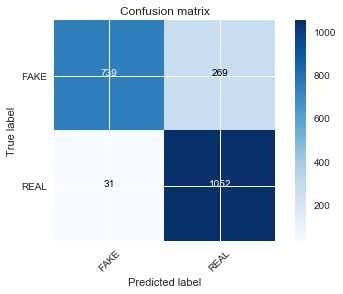

In [197]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [198]:
clf = MultinomialNB() 

accuracy:   0.893
Confusion matrix, without normalization


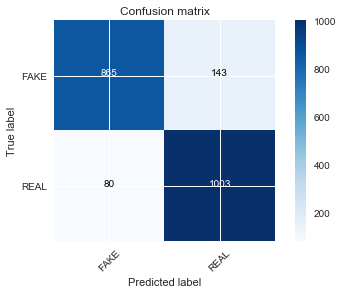

In [199]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Linear model test

Passive Agressive classifier is another tool used in text classification. I will test this technique here.

In [200]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)

accuracy:   0.936
Confusion matrix, without normalization


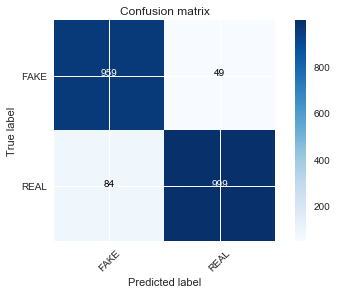

In [201]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

This Linear model classifies fake news a little better. 

In [202]:
clf = MultinomialNB(alpha=0.1)

In [203]:
last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))


Alpha: 0.00 Score: 0.61502
Alpha: 0.10 Score: 0.89766
Alpha: 0.20 Score: 0.89383
Alpha: 0.30 Score: 0.89000
Alpha: 0.40 Score: 0.88570
Alpha: 0.50 Score: 0.88427
Alpha: 0.60 Score: 0.87470
Alpha: 0.70 Score: 0.87040
Alpha: 0.80 Score: 0.86609
Alpha: 0.90 Score: 0.85892


Changing the alpha values of MultinomialNB does not create comparable results to that of the Linear model. 

# Finding vectors that most affect labels

The write-up on the following link, https://stackoverflow.com/a/26980472, provides us with a useful method of finding out the vectors that affect labels the most.

This would work well in this case, since our model is a Binary Classification (Real or Fake labels).  

In [217]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show.
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)

('FAKE', -4.9577199524432158, u'2016')
('FAKE', -3.9931690303724108, u'october')
('FAKE', -3.9617595201245144, u'hillary')
('FAKE', -3.1970640913030532, u'share')
('FAKE', -2.9532977995730127, u'article')
('FAKE', -2.8979037472273546, u'november')
('FAKE', -2.5400479583417339, u'print')
('FAKE', -2.4790726806041081, u'oct')
('FAKE', -2.4767259003247046, u'email')
('FAKE', -2.367015908189011, u'source')
('FAKE', -2.1532453743691913, u'war')
('FAKE', -2.152150534672356, u'advertisement')
('FAKE', -2.1128724063623703, u'podesta')
('FAKE', -2.0786273760435177, u'mosul')
('FAKE', -2.0138856674436578, u'election')
('FAKE', -1.9859625067894042, u'establishment')
('FAKE', -1.8924793211210058, u'nov')
('FAKE', -1.85976855023202, u'pipeline')
('FAKE', -1.8513343329241967, u'com')
('FAKE', -1.82734130031202, u'wikileaks')
('FAKE', -1.8248719831306439, u'corporate')
('FAKE', -1.7434231004062115, u'26')
('FAKE', -1.6923507405099116, u'reuters')
('FAKE', -1.689384044900222, u'jewish')
('FAKE', -1.67

We can also do this in a shorter way, by zipping the coefficients to features and looking at the top and bottom of the list.

In [218]:
feature_names = tfidf_vectorizer.get_feature_names()

In [219]:
# Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

[(-6.2573612147015822, u'trump'),
 (-6.4944530943126777, u'said'),
 (-6.6539784739838845, u'clinton'),
 (-7.0379446628670728, u'obama'),
 (-7.1465399833812278, u'sanders'),
 (-7.2153760086475112, u'president'),
 (-7.2665628057416169, u'campaign'),
 (-7.2875931446681514, u'republican'),
 (-7.3411184585990643, u'state'),
 (-7.3413571102479054, u'cruz'),
 (-7.3783124419854254, u'party'),
 (-7.4468806724578904, u'new'),
 (-7.4762888011545883, u'people'),
 (-7.547225599514773, u'percent'),
 (-7.5553074094582335, u'bush'),
 (-7.5801506339098932, u'republicans'),
 (-7.5855405012652435, u'house'),
 (-7.6344781725203141, u'voters'),
 (-7.6484824436952987, u'rubio'),
 (-7.6734836186463795, u'states')]

In [216]:
#Most fake
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-11.349866225220305, u'0000'),
 (-11.349866225220305, u'000035'),
 (-11.349866225220305, u'0001'),
 (-11.349866225220305, u'0001pt'),
 (-11.349866225220305, u'000km'),
 (-11.349866225220305, u'0011'),
 (-11.349866225220305, u'006s'),
 (-11.349866225220305, u'007'),
 (-11.349866225220305, u'007s'),
 (-11.349866225220305, u'008s'),
 (-11.349866225220305, u'0099'),
 (-11.349866225220305, u'00am'),
 (-11.349866225220305, u'00p'),
 (-11.349866225220305, u'00pm'),
 (-11.349866225220305, u'014'),
 (-11.349866225220305, u'015'),
 (-11.349866225220305, u'018'),
 (-11.349866225220305, u'01am'),
 (-11.349866225220305, u'020'),
 (-11.349866225220305, u'023')]